In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
# from learn import *
import math

```
tau: 0.125
alpha: 15.0
beta: 3.75
num_dims: 3
num_basis: 31
num_sensors: 4
mu: (31,)
h: (31,)
phi_j: (4,)
weights: (3, 4, 31)
```

In [2]:
pose_dmp_file = open("IROS2020_dmp_data_goal_position_weights.pkl","rb")
pose_dmp_info = pickle.load(pose_dmp_file)

In [6]:
pose_dmp_info["weights"]

[[[1.0,
   0.055828249088950864,
   0.05795235142264939,
   0.05854027369880218,
   0.05945457931396051,
   0.061028831563687,
   0.06162296542174947,
   0.06353780876425687,
   0.06329612040168733,
   0.02454547460407674,
   0.09365051451599488,
   0.043942222428182534,
   0.08001516458907333,
   0.05689110532800799,
   0.06536513830868988,
   0.1448947435972877,
   0.046287874542880844,
   0.08114711289769927,
   0.019493107482898977,
   0.14613472546090792,
   0.030536812370608526,
   0.1718274648172914,
   0.01443803960295366,
   0.13944053858054925,
   0.059092262804408505,
   0.09591779702880363,
   0.08853997690076194,
   0.12245112590095936,
   0.10438006804963945,
   0.09018594840499711,
   0.11971503953212223],
  [0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,
   -0.0,


In [3]:
with open("demo0.pkl", "rb") as f:
    raw_traj = pickle.load(f)
trajectory = np.stack(raw_traj["pose"])
t = np.stack(raw_traj["t"])
t = t - t[0]

In [4]:
def derivative(x, t):
    dt = np.append(t[1:], np.nan) - t
    dx = np.append(x[1:], np.nan) - x
    xd = dx / dt

    # prev_max = max(xd)
#     xd = gaussian_filter1d(xd, 3)
    # xd = xd / (prev_max - max(xd))
    return xd

In [5]:
def plot_path(traj):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter3D(traj[:, 0], traj[:, 1], traj[:, 2], cmap='Greens');
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(traj[:, 0], label="x")
    ax.plot(traj[:, 1], label="y")
    ax.plot(traj[:, 2], label="z")
    ax.legend()


C:\Users\chian\AppData\Local\Temp\ipykernel_5548\3497018087.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(traj[:, 0], traj[:, 1], traj[:, 2], cmap='Greens');


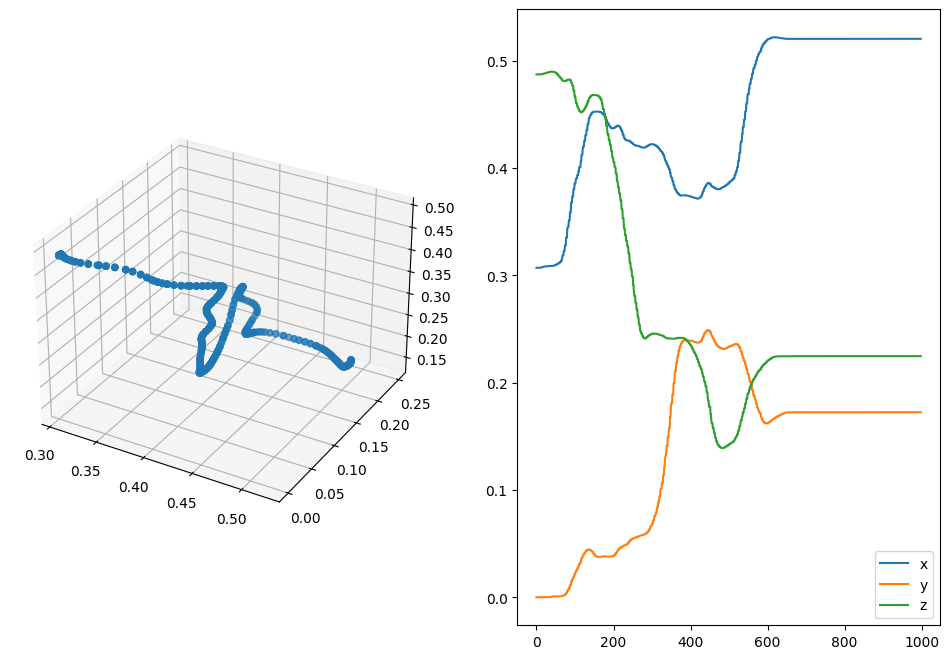

In [6]:
plot_path(trajectory)

In [7]:
def plot_f(f, fitted=None):
    fig, ax = plt.subplots(1,1,  figsize=(12, 8))
    ax.plot(f, label="x")
    if fitted is not None:
        ax.plot(fitted, label="fitted")
    ax.legend()

In [8]:
# https://www.askpython.com/python/normal-distribution
def normal_dist(x, mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

In [9]:
def plot_distributions(t, mu, h):
    fig, ax = plt.subplots(1,1,  figsize=(12, 8))
    sample = 10000
    for i, j in zip(mu, h):
        x = [t / sample for t in range(sample)]
        y = [normal_dist(x_i, i, j) for x_i in x]
        ax.plot(y)

def plot_fns(fns):
    fig, ax = plt.subplots(1,1,  figsize=(12, 8))
    for f in fns:
        ax.plot(f)

The parameter τ must be adjusted to the duration of the demonstration.
In practice, extracting τ from a recorded trajectory may require some
thresholding in order to detect the movement onset and end. For in-
stance, a velocity threshold of 2% of the maximum velocity in the move-
ment may be employed, and τ could be chosen as 1.05 times the duration
of this thresholded trajectory piece. The factor 1.05 is to compensate for
the missing tails in the beginning and the end of the trajectory due to
thresholding

In [10]:
def get_f_integrate(x, t, alpha, beta):
    # get forcing function from demonstration
    # print(t)
    T = t[-1]
    g = x[-1]
    xd = derivative(x, t)
    xdd = derivative(xd, t)
    f = [0]
    K = alpha
    B = beta
    q0 = x[0]
    q = x[0]
    qd = 0
    qdd = 0
    # todo xd and x should be NOT WHAT WAS DEMO'D
    prev_t = 0
    for t_i in t:
        dt = t_i - prev_t
        qdd = K * (g - q) * (T**-2)  - B * qd * (T**-1) + (g - q) * f[-1] * (T ** -2)
        qd = qd + qdd * dt
        q = q + qd * dt
        prev_t = t_i
        f.append((qdd * (T ** 2) - K * (g - q) + B * qd * T) / (g - q0))

    f = np.nan_to_num(np.array(f[1:]))

    return f

def get_f(x, t, alpha, beta):
    # get forcing function from demonstration
    # print(t)
    T = t[-1]
    q0 = x[0]
    g = x[-1]
    xd = derivative(x, t)
    xdd = derivative(xd, t)
    f = []
    K = alpha
    B = beta
    for q, qd, qdd in zip(x, xd, xdd):
        # qdd = K * (g - q) * (T**-2)  - B * qd * (T**-1) + (g - q0) * (T ** -2)
        f.append((qdd * (T ** 2) - K * (g - q) + B * qd * T) / (g - q0))
    f = np.nan_to_num(np.array(f))
    return f

In [11]:
def learn_weights(traj, t, n_basis=31, alpha=15.0, beta=3.75, tau=0.125, C=None, H=None):
    if C == None:
        C = np.linspace(0, 1, n_basis)
    if H == None:
        H = [(0.65 * (1./(n_basis-1)) ** 2) for _ in range(len(C))]

    out = {
        'tau': tau,
        'alpha': alpha,
        'beta': beta,
        'num_dims': 3,
        'num_basis': n_basis,
        'num_sensors': 1,
        'phi_j': [1.0],
        'mu': list(C),
        'h': H,
    }
    # Phi = np.array([np.exp(-0.5 * ((t / max(t)) - c)**2 / h) for c, h in zip(C, H)])
    # todo this doesn't work
    # Phi = np.array([-h * np.exp((t / max(t) - c)**2) for c, h in zip(C, H)])
    phi = np.array([np.exp(-0.5 * ((t/max(t)) - c) ** 2 / h) for c, h in zip(C, H)])
    phi = phi / np.sum(phi, axis=0)
    phi = np.nan_to_num(np.array(phi))
    weights = []
    for axis in range(0, 3):
        smoothed = gaussian_filter1d(traj[:, axis], 3)
        f_axis = get_f(smoothed, t, alpha, beta)
        w = (np.linalg.inv(phi @ phi.T) @ phi) @ f_axis
        weights.append(w)
    weights = np.stack(weights)
    weights = np.expand_dims(weights, axis=1)
    out["weights"] = weights
    return out


In [12]:
def get_forcing_function(t, mu, h, weights):
    out = []
    T = max(t)
    for dim in range(weights.shape[0]):
        dim_f = []
        phi = np.array([np.exp(-0.5 * ((t/max(t)) - c) ** 2 / h) for c, h in zip(mu, h)])
        phi = phi / np.sum(phi, axis=0)
        phi = np.nan_to_num(np.array(phi))
        numerator = phi * np.tile(weights[dim][0], (999, 1)).T
        print(numerator.shape)
        f_t = np.sum(numerator, axis=0)/np.sum(phi)
        print(f_t.shape)
        out.append(f_t)
    return np.array(out)
            

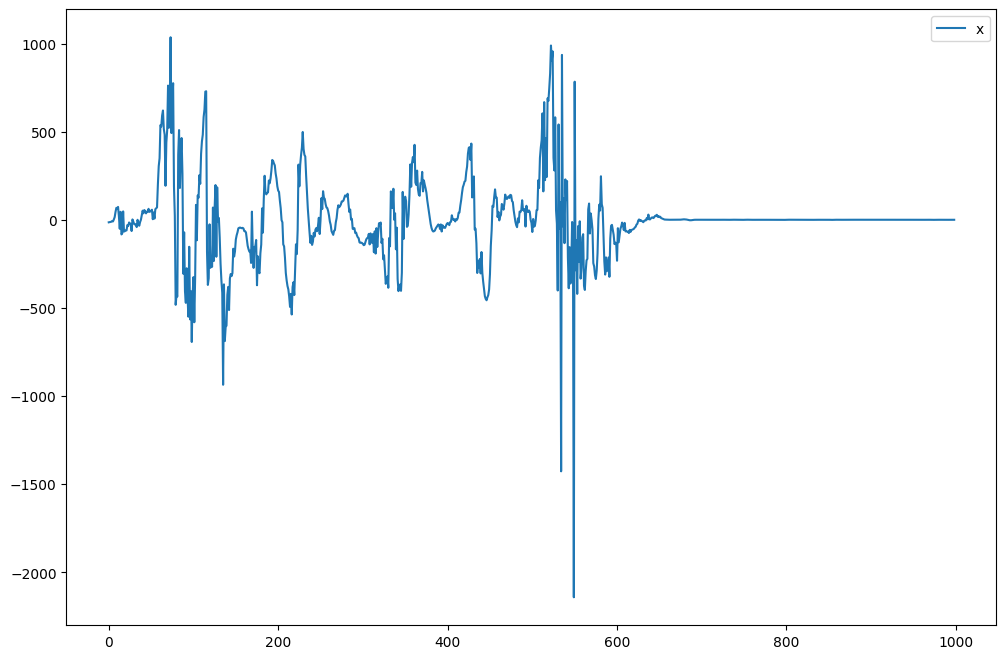

In [13]:
weights = learn_weights(trajectory, t)
smoothed = gaussian_filter1d(trajectory[:, 0], 3)
f_x = get_f(smoothed, t, alpha=15, beta=3.75)
plot_f(f_x)

(31, 999)
(999,)
(31, 999)
(999,)
(31, 999)
(999,)


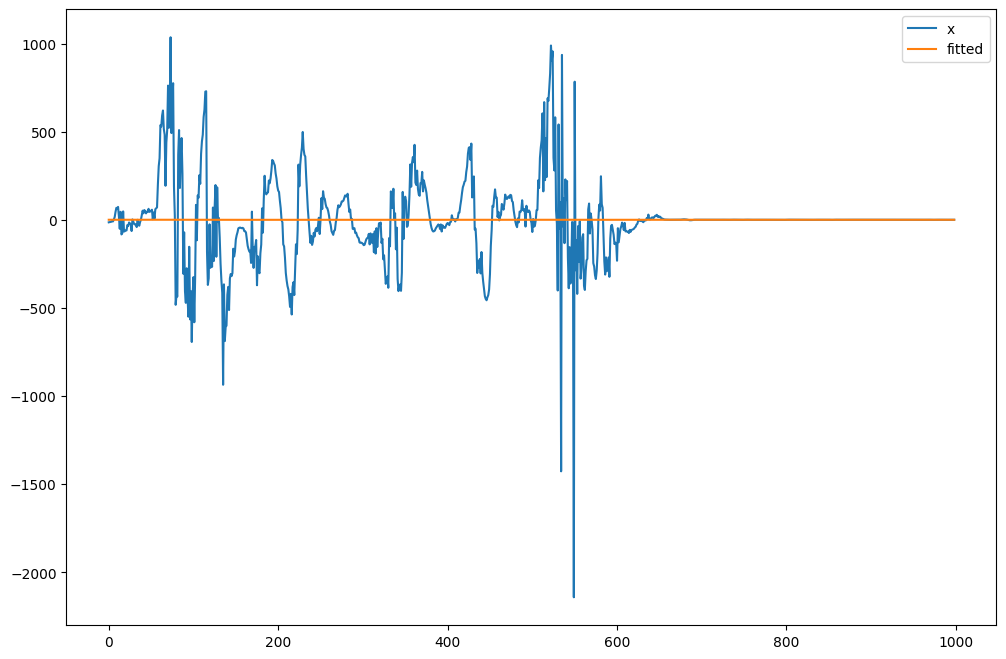

In [14]:

f_hat = get_forcing_function(t, weights["mu"], weights["h"], weights["weights"])
plot_f(f_x, f_hat[0])


In [15]:
# plot_distributions(t, weights["mu"], weights["h"])

In [16]:
def get_pos_from_f(t, x0, g, C, H, weights, alpha=15, beta=3.75):
    T = t[-1]
    q0 = x0
    K = alpha
    B = beta
    q = q0
    qd = 0
    qdd = 0
    qdd_list = [qdd]
    qd_list = [qd]
    q_list = [q]
    prev_t = 0
    for t_i in t:        
        phi = np.array([math.exp(-0.5 * ((t_i/T) - c) ** 2 / h) for c, h in zip(C, H)])
        phi = phi / np.sum(phi)
        f_t = np.dot(phi, weights)
        
        qdd = K * (g - q) * (T**-2) - B * qd * (T**-1) + (g - q0) * f_t * (T ** -2)
        qd = qd +  qdd * (t_i - prev_t)
        q = q + qd * (t_i - prev_t)
        prev_t = t_i
        qdd_list.append(qdd)
        qd_list.append(qd)
        q_list.append(q)
    return q_list, qd_list, qdd_list

In [17]:

q, qd, qdd = get_pos_from_f(
    np.linspace(0, 10, 1001), 
    trajectory[:, 0][0], 
    trajectory[:, 0][-1], 
    weights["mu"], 
    weights["h"], 
    weights["weights"][0][0], 
    alpha=15, 
    beta=3.75
)

In [18]:
trajectory[:, 0][-1]

0.5203015364829576

In [19]:
q[-1]

0.5111579941598027

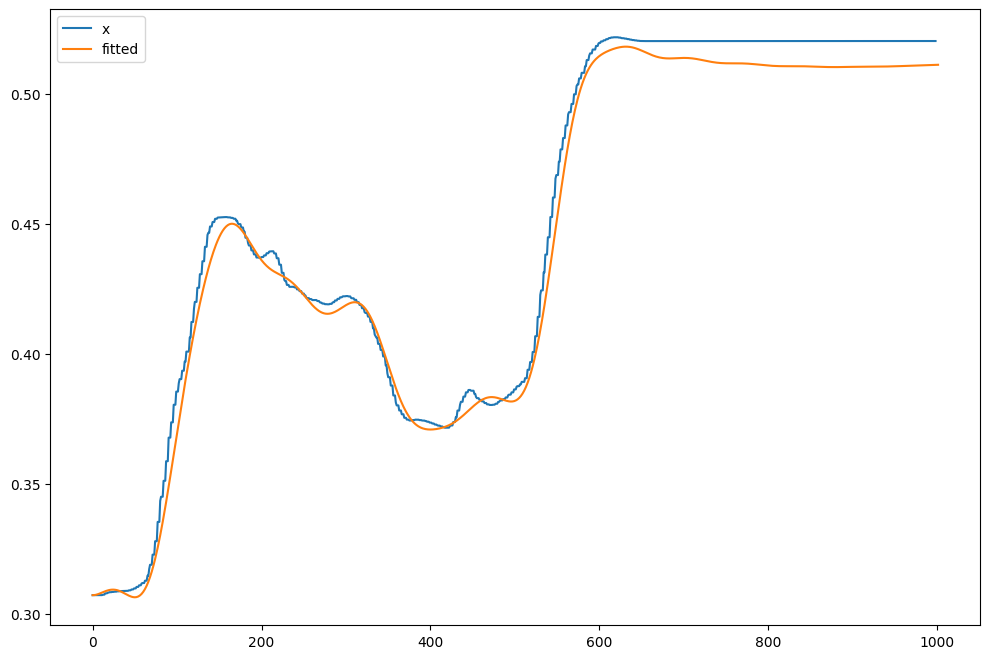

In [21]:
plot_f(trajectory[:, 0],q)

In [ ]:
x = gaussian_filter1d(trajectory[:, 0], 3)
# x = trajectory[:, 0]
xd = derivative(x, t)
xdd = derivative(xd, t)
plot_f(x)
plot_f(xd)
plot_f(xdd)